# Goal: given bbox and time construct ATL03 database (footprint + timestamp)

based on https://git.earthdata.nasa.gov/projects/LPDUR/repos/cmr-api---hls-bulk-query/browse

Steps:

1. do it serial
2. use an async function

In [1]:
import requests
import math
import aiohttp
import asyncio
import time

import pandas as pd
import shapely
import geopandas as gpd

In [2]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search' # CMR API Endpoint
url = f'{CMR_OPS}/{"granules"}'
print(url)

https://cmr.earthdata.nasa.gov/search/granules


## Smallish testcase

In [3]:
# https://github.com/Element84/cmr-stac-api-proxy/issues/30
collections = ['C2120512202-NSIDC_ECS']
datetime_range = '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z'
bbox = '-170,60,-140,70' # most of alaska
page_size = 2000

In [4]:
%%time

# All time: 5.44s, 4039 granules
# 2021-10-17 to 19: Wall time: 1.8 s, 9 granules, 300-640 ms today, seems quite variable...

response = requests.get(url, 
                        params={
                            'concept_id': collections,
                            'temporal': datetime_range,
                            'bounding_box': bbox,
                            'page_size': page_size,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)

200
CPU times: user 42.2 ms, sys: 3.55 ms, total: 45.7 ms
Wall time: 1.07 s


In [5]:
print(response.headers['CMR-Hits']) # Resulting quantity of granules/items.

9


In [6]:
%%time
# Actually get JSON per granule (1st 2000 hits)
granules = response.json()['feed']['entry']

CPU times: user 474 µs, sys: 308 µs, total: 782 µs
Wall time: 787 µs


In [7]:
# Just create a dataframe with the basics
keys = ['producer_granule_id', 'time_start', 'time_end', 'polygons'] #, ?link {key: old_dict[key] for key in your_keys}

# nested list comprehension to filter dictionaries
df = pd.DataFrame([{key: x[key] for key in keys} for x in granules])
df.head()

,producer_granule_id,time_start,time_end,polygons
0,ATL03_20211017095408_03811305_005_01.h5,2021-10-17T09:54:08.705Z,2021-10-17T09:59:33.831Z,[[82.61181287249774 -145.06163097699368 64.252...
1,ATL03_20211017204335_03881303_005_01.h5,2021-10-17T20:43:36.058Z,2021-10-17T20:49:01.491Z,[[57.70233662448695 -148.15869641435995 76.195...
2,ATL03_20211018092829_03961305_005_01.h5,2021-10-18T09:28:29.226Z,2021-10-18T09:33:54.653Z,[[82.5525316835928 -139.49564575164013 64.1910...
3,ATL03_20211018201756_04031303_005_01.h5,2021-10-18T20:17:56.827Z,2021-10-18T20:23:22.267Z,[[57.70233662448695 -142.44838395035342 76.195...
4,ATL03_20211018215214_04041303_005_01.h5,2021-10-18T21:52:14.265Z,2021-10-18T21:57:39.707Z,[[57.70233662448695 -166.06800557681 76.195857...


In [8]:
df['time_start'] = pd.to_datetime(df.time_start).dt.tz_localize(None)
df['time_end'] = pd.to_datetime(df.time_end).dt.tz_localize(None)
df['datetime'] = df.time_start + (df.time_end - df.time_start)/2
df.head()

,producer_granule_id,time_start,time_end,polygons,datetime
0,ATL03_20211017095408_03811305_005_01.h5,2021-10-17 09:54:08.705,2021-10-17 09:59:33.831,[[82.61181287249774 -145.06163097699368 64.252...,2021-10-17 09:56:51.268000
1,ATL03_20211017204335_03881303_005_01.h5,2021-10-17 20:43:36.058,2021-10-17 20:49:01.491,[[57.70233662448695 -148.15869641435995 76.195...,2021-10-17 20:46:18.774500
2,ATL03_20211018092829_03961305_005_01.h5,2021-10-18 09:28:29.226,2021-10-18 09:33:54.653,[[82.5525316835928 -139.49564575164013 64.1910...,2021-10-18 09:31:11.939500
3,ATL03_20211018201756_04031303_005_01.h5,2021-10-18 20:17:56.827,2021-10-18 20:23:22.267,[[57.70233662448695 -142.44838395035342 76.195...,2021-10-18 20:20:39.547000
4,ATL03_20211018215214_04041303_005_01.h5,2021-10-18 21:52:14.265,2021-10-18 21:57:39.707,[[57.70233662448695 -166.06800557681 76.195857...,2021-10-18 21:54:56.986000


In [9]:
def polygons2shapely(polygons):
    ''' convert CMR string to shapely polygon for geopandas '''
    coordlist = polygons[0][0].split() #list of lists (assume just one though)
    lats = [float(x) for x in coordlist[::2]]
    lons = [float(x) for x in coordlist[1::2]]
    poly = shapely.geometry.Polygon(zip(lons,lats))
    # Proper orientation to denote exterior boundary (poly.exterior.is_ccw)
    poly = shapely.geometry.polygon.orient(poly)
    return poly

In [10]:
poly = polygons2shapely(df.polygons.values[0])

In [11]:
poly.exterior.is_ccw

True

In [12]:
df['geometry'] = df.polygons.apply(lambda x: polygons2shapely(x))

In [13]:
gf = gpd.GeoDataFrame(df, crs='EPSG:4326')
gf.head()

,producer_granule_id,time_start,time_end,polygons,datetime,geometry
0,ATL03_20211017095408_03811305_005_01.h5,2021-10-17 09:54:08.705,2021-10-17 09:59:33.831,[[82.61181287249774 -145.06163097699368 64.252...,2021-10-17 09:56:51.268000,"POLYGON ((-145.06163 82.61181, -147.49978 82.7..."
1,ATL03_20211017204335_03881303_005_01.h5,2021-10-17 20:43:36.058,2021-10-17 20:49:01.491,[[57.70233662448695 -148.15869641435995 76.195...,2021-10-17 20:46:18.774500,"POLYGON ((-148.15870 57.70234, -147.55355 57.7..."
2,ATL03_20211018092829_03961305_005_01.h5,2021-10-18 09:28:29.226,2021-10-18 09:33:54.653,[[82.5525316835928 -139.49564575164013 64.1910...,2021-10-18 09:31:11.939500,"POLYGON ((-139.49565 82.55253, -141.91582 82.6..."
3,ATL03_20211018201756_04031303_005_01.h5,2021-10-18 20:17:56.827,2021-10-18 20:23:22.267,[[57.70233662448695 -142.44838395035342 76.195...,2021-10-18 20:20:39.547000,"POLYGON ((-142.44838 57.70234, -141.84324 57.7..."
4,ATL03_20211018215214_04041303_005_01.h5,2021-10-18 21:52:14.265,2021-10-18 21:57:39.707,[[57.70233662448695 -166.06800557681 76.195857...,2021-10-18 21:54:56.986000,"POLYGON ((-166.06801 57.70234, -165.46286 57.7..."


<Axes: >

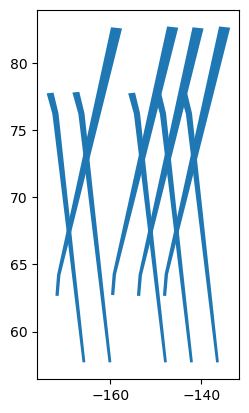

In [14]:
gf.plot()

## Most of alaska 

In [15]:
params={
    'concept_id': ['C2120512202-NSIDC_ECS'],
    #'temporal': '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z',
    'bounding_box': '-170,60,-140,70',
    'page_size': 2000,
    }

In [16]:
def get_page_total(params):
    hits = requests.get(url, 
                        params=params,
                        headers={
                            'Accept': 'application/json'
                            }
                       ).headers['CMR-Hits']
    
    print(f'Granules= {hits}') 
    pages = math.ceil(int(hits)/params['page_size'])
    print(f'Pages= {pages}')
    
    return pages

In [17]:
%%time
get_page_total(params)

Granules= 4039
Pages= 3
CPU times: user 87.2 ms, sys: 12 ms, total: 99.2 ms
Wall time: 3.69 s


3

In [18]:
def get_cmr_granules(params):
    response = requests.get("https://cmr.earthdata.nasa.gov/search/granules", 
                        params=params,
                        headers={
                            'Accept': 'application/json'
                            }
                       )
    
    
    granules = response.json()['feed']['entry']
    keys = ['producer_granule_id', 'time_start', 'time_end', 'polygons']
    df = pd.DataFrame([{key: x[key] for key in keys} for x in granules])
    return df

In [19]:
%%time

df = get_cmr_granules(params)
df.head(3)

CPU times: user 291 ms, sys: 23.7 ms, total: 314 ms
Wall time: 2.17 s


,producer_granule_id,time_start,time_end,polygons
0,ATL03_20181014015337_02360103_005_01.h5,2018-10-14T01:53:36.912Z,2018-10-14T01:59:02.315Z,[[57.70233662448695 -158.02215135775847 76.195...
1,ATL03_20181014130413_02430105_005_01.h5,2018-10-14T13:04:12.567Z,2018-10-14T13:09:37.946Z,[[82.61181287249774 -125.59579916774838 64.252...
2,ATL03_20181014143830_02440105_005_01.h5,2018-10-14T14:38:29.879Z,2018-10-14T14:43:55.296Z,[[82.61181287249774 -149.2145298179909 64.2527...


## ASYNC

In [20]:
params={
    'concept_id': ['C2120512202-NSIDC_ECS'],
    #'temporal': '2021-10-17T00:00:00Z,2021-10-19T23:59:59Z',
    'bounding_box': '-170,60,-140,70',
    'page_size': 2000,
    }

In [21]:
def get_cmr_pages_urls(params): 
    response = requests.get('https://cmr.earthdata.nasa.gov/search/granules',
                       params=params,
                       headers={
                           'Accept': 'application/json'
                       }
                      )
    hits = int(response.headers['CMR-Hits'])
    n_pages = math.ceil(hits/page_size)
    cmr_pages_urls = [f'{response.url}&page_num={x}'.replace('granules?', 'granules.json?') for x in list(range(1,n_pages+1))]
    return cmr_pages_urls

In [22]:
urls = get_cmr_pages_urls(params)
urls

['https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2120512202-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=1',
 'https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2120512202-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=2',
 'https://cmr.earthdata.nasa.gov/search/granules.json?concept_id=C2120512202-NSIDC_ECS&bounding_box=-170%2C60%2C-140%2C70&page_size=2000&page_num=3']

In [23]:
results = []

In [24]:
def get_tasks(session):
    tasks = []
    for l in urls:
        tasks.append(session.get(l))
    return tasks

In [25]:
async def get_url():
    async with aiohttp.ClientSession() as session:
        tasks = get_tasks(session)
        responses = await asyncio.gather(*tasks)
        for response in responses:
            res = await response.json()
            #print(res)
            granules = res['feed']['entry']
            results.extend([{key: x[key] for key in keys} for x in granules])

In [26]:
start = time.time() 

await get_url()

end = time.time()

total_time = end - start
total_time

16.946277618408203

In [27]:
len(results)

4039

In [28]:
%%time 

df = pd.DataFrame(results)
df.head(3)

CPU times: user 5.15 ms, sys: 445 µs, total: 5.59 ms
Wall time: 5.11 ms


,producer_granule_id,time_start,time_end,polygons
0,ATL03_20181014015337_02360103_005_01.h5,2018-10-14T01:53:36.912Z,2018-10-14T01:59:02.315Z,[[57.70233662448695 -158.02215135775847 76.195...
1,ATL03_20181014130413_02430105_005_01.h5,2018-10-14T13:04:12.567Z,2018-10-14T13:09:37.946Z,[[82.61181287249774 -125.59579916774838 64.252...
2,ATL03_20181014143830_02440105_005_01.h5,2018-10-14T14:38:29.879Z,2018-10-14T14:43:55.296Z,[[82.61181287249774 -149.2145298179909 64.2527...


In [29]:
#%%time 
# non-blocking for some reason so %%time doesn work...

start = time.time() 

# Add midpoint time, coerce to shapely geometry.
# NOTE: make this faster? 
df['time_start'] = pd.to_datetime(df.time_start).dt.tz_localize(None)
df['time_end'] = pd.to_datetime(df.time_end).dt.tz_localize(None)
df['datetime'] = df.time_start + (df.time_end - df.time_start)/2
df['geometry'] = df.polygons.apply(lambda x: polygons2shapely(x))
gf = gpd.GeoDataFrame(df.drop(columns='polygons'), crs='EPSG:4326')


end = time.time()
total_time = end - start
total_time

0.9249539375305176

In [30]:
gf.head()

,producer_granule_id,time_start,time_end,datetime,geometry
0,ATL03_20181014015337_02360103_005_01.h5,2018-10-14 01:53:36.912,2018-10-14 01:59:02.315,2018-10-14 01:56:19.613500,"POLYGON ((-158.02215 57.70234, -157.41701 57.7..."
1,ATL03_20181014130413_02430105_005_01.h5,2018-10-14 13:04:12.567,2018-10-14 13:09:37.946,2018-10-14 13:06:55.256500,"POLYGON ((-125.59580 82.61181, -128.03395 82.7..."
2,ATL03_20181014143830_02440105_005_01.h5,2018-10-14 14:38:29.879,2018-10-14 14:43:55.296,2018-10-14 14:41:12.587500,"POLYGON ((-149.21453 82.61181, -151.65268 82.7..."
3,ATL03_20181015012758_02510103_005_01.h5,2018-10-15 01:27:57.020,2018-10-15 01:33:22.415,2018-10-15 01:30:39.717500,"POLYGON ((-152.32414 57.76417, -151.71796 57.7..."
4,ATL03_20181015141251_02590105_005_01.h5,2018-10-15 14:12:49.940,2018-10-15 14:18:15.349,2018-10-15 14:15:32.644500,"POLYGON ((-143.50439 82.61181, -145.94254 82.7..."


In [32]:
len(gf)

4039

In [33]:
gf.to_file('IS2_Alaska.geojson', driver='GeoJSON')

In [34]:
gf.to_file('IS2_Alaska.gpkg', driver='GPKG')

In [35]:
gf.to_parquet('IS2_Alaska.parquet', version='2.6')

In [36]:
!ls -lh IS2*

-rw-r--r-- 1 jovyan users 2.4M Mar  8 22:40 IS2_Alaska.geojson
-rw-r--r-- 1 jovyan users 1.5M Mar  8 22:40 IS2_Alaska.gpkg
-rw-r--r-- 1 jovyan users 245K Mar  8 22:40 IS2_Alaska.parquet

IS2I:
total 4.0M
-rw-r--r-- 1 jovyan users 2.4M Mar  8 22:21 IS2_Alaska.geojson
-rw-r--r-- 1 jovyan users 1.5M Mar  8 22:22 IS2_Alaska.gpkg
-rw-r--r-- 1 jovyan users 245K Mar  8 22:22 IS2_Alaska.parquet
-rw-r--r-- 1 jovyan users 1.1K Mar  8 22:25 LICENSE
-rw-r--r-- 1 jovyan users   26 Mar  8 22:25 README.md


In [37]:
test = gpd.read_file('IS2_Alaska.geojson')

In [38]:
test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   producer_granule_id  4039 non-null   object        
 1   time_start           4039 non-null   datetime64[ns]
 2   time_end             4039 non-null   datetime64[ns]
 3   datetime             4039 non-null   datetime64[ns]
 4   geometry             4039 non-null   geometry      
dtypes: datetime64[ns](3), geometry(1), object(1)
memory usage: 157.9+ KB


In [39]:
gf = gpd.read_file('https://github.com/scottyhq/IS2I/raw/main/IS2_Alaska.geojson')
gf.head(3)

,producer_granule_id,time_start,time_end,datetime,geometry
0,ATL03_20181014015337_02360103_005_01.h5,2018-10-14 01:53:36.912,2018-10-14 01:59:02.315,2018-10-14 01:56:19.614,"POLYGON ((-158.02215 57.70234, -164.65924 76.1..."
1,ATL03_20181014130413_02430105_005_01.h5,2018-10-14 13:04:12.567,2018-10-14 13:09:37.946,2018-10-14 13:06:55.257,"POLYGON ((-125.59580 82.61181, -139.25558 64.2..."
2,ATL03_20181014143830_02440105_005_01.h5,2018-10-14 14:38:29.879,2018-10-14 14:43:55.296,2018-10-14 14:41:12.588,"POLYGON ((-149.21453 82.61181, -162.87431 64.2..."
